In [2]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization

from ase.build import bulk
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

import pickle

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [3]:
path_pp='/Users/valeria/Documents/PP/ofpp/EAC/upf/blps/'
file='si.lda.upf'
PP_list = {'Si': path_pp+file}

In [4]:
rho0 = np.load('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_Btin/DATA2/rho0_den.npy')

In [7]:
l = np.linspace(0.8, 1.4, 30)
rho0 = np.asarray(rho0)
XC = Functional(type='XC',name='LDA')
HARTREE = Functional(type='HARTREE')
ENERGY = []
VOLUME = []
RHO = []
for n in np.arange(0, 30, 1):
        i = int(n) 
        KE = Functional(type='KEDF',name='WT', rho0=rho0[i])
        ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
        cell = ions.get_cell()
        ions.set_cell(cell * l[i], scale_atoms=True)
        ions.set_charges(4)
        nr = ecut2nr(ecut=25, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=nr)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        
        optimization_options = {'econv' : 1e-5*ions.nat}
        opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        rho = opt.optimize_rho(guess_rho=rho_ini)
        rho.write('/Users/valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_Btin/DATA2/den_rho_'+str(i)+'.xsf', ions=ions)
        energy = evaluator.Energy(rho=rho, ions=ions)
        vol=ions.get_volume()
        ENERGY.append(energy)
        VOLUME.append(vol)
        RHO.append(rho)

setting key: Si -> /Users/valeria/Documents/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -1.454472427299E+01     -1.454472E+01   4.864010E+00    1       1       5.630255E-03    
1       -1.553504138088E+01     -9.903171E-01   2.626297E-01    4       2       1.203036E-02    
2       -1.555102028482E+01     -1.597890E-02   1.824956E-02    4       1       1.654243E-02    
3       -1.555310439854E+01     -2.084114E-03   1.036941E-03    6       1       2.250528E-02    
4       -1.555316200115E+01     -5.760261E-05   7.316609E-05    4       1       2.693915E-02    
5       -1.555316913298E+01     -7.131827E-06   6.892205E-06    5       1       3.229904E-02    
6       -1.555316971635E+01     -5.833732E-07   5.178434E-07    6       1       4.002428E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.7735330745805371
Chemical potential (eV)  : 21.048907095026653
setting key: Si

In [10]:
from dftpy.formats import io
Rho_of = []
Rho_ks = []
for i in np.arange(0, 30, 1):
    of_rho = io.read_density('/Users/valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_Btin/DATA2/den_rho_'+str(i)+'.xsf')
    ks_rho = io.read_density('/Users/Valeria/Documents/aiWT/Model_ML_function/training_set_data/ks_calculations/Si_Btin/DATA2/rho0'+str(i)+'.xsf')
    Rho_of.append(of_rho)
    Rho_ks.append(ks_rho)

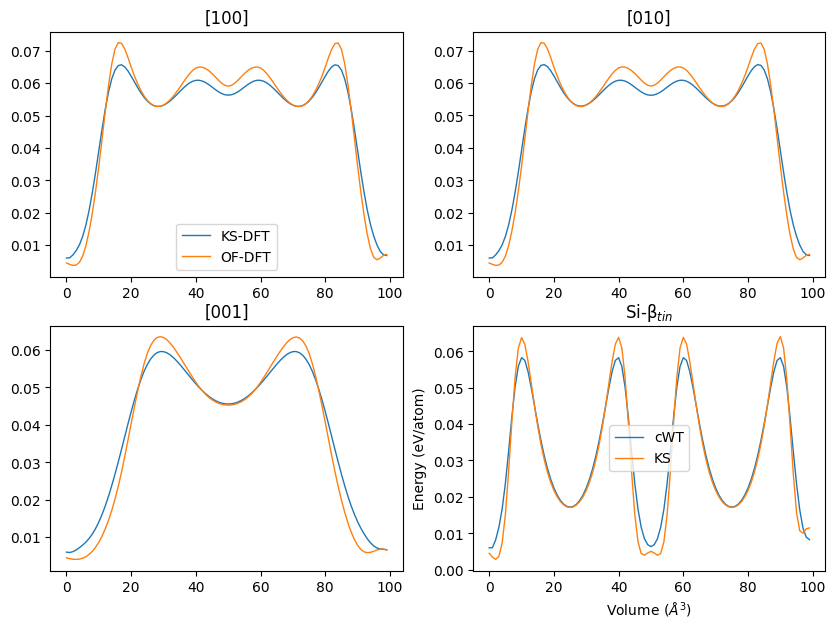

In [11]:
ks_index = 10
of_index = 10
fig, axs = plt.subplots(2,2, figsize=(10,7))
axs[0,0].set_title('[100]')
axs[0,1].set_title('[010]')
axs[1,0].set_title('[001]')
axs[1,1].set_title('[111]')

d_1 = Rho_ks[ks_index].get_cut(r0=[1,0,0], origin=[0,0,0], nr=100, basis='crystal')
axs[0,0].plot(d_1.ravel(), linewidth=1,label='KS-DFT')
d_1 = Rho_of[of_index].get_cut(r0=[1,0,0], origin=[0,0,0], nr=100, basis='crystal')
axs[0,0].plot(d_1.ravel(), linewidth=1,label='OF-DFT')
d_2 = Rho_ks[ks_index].get_cut(r0=[0,1,0], origin=[0,0,0], nr=100, basis='crystal')
axs[0,1].plot(d_2.ravel(), linewidth=1,label='KS-DFT')
d_2 = Rho_of[of_index].get_cut(r0=[0,1,0], origin=[0,0,0], nr=100, basis='crystal')
axs[0,1].plot(d_2.ravel(), linewidth=1,label='OF-DFT')

d_3 = Rho_ks[ks_index].get_cut(r0=[0,0,1], origin=[0,0,0], nr=100, basis='crystal')
axs[1,0].plot(d_3.ravel(), linewidth=1,label='KS-DFT')
d_3 = Rho_of[of_index].get_cut(r0=[0,0,1], origin=[0,0,0], nr=100, basis='crystal')
axs[1,0].plot(d_3.ravel(), linewidth=1,label='OF-DFT')

d_4 = Rho_ks[ks_index].get_cut(r0=[1,1,1], origin=[0,0,0], nr=100, basis='crystal')
axs[1,1].plot(d_4.ravel(), linewidth=1,label='KS-DFT')
d_4 = Rho_of[of_index].get_cut(r0=[1,1,1], origin=[0,0,0], nr=100, basis='crystal')
axs[1,1].plot(d_4.ravel(), linewidth=1,label='OF-DFT')
axs[0,0].legend()

plt.xlabel('Volume ($\AA^{3}$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si-\u03B2$_{tin}$')
plt.legend(['cWT','KS'])